In [ ]:
import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate

In [ ]:
# Generate data
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

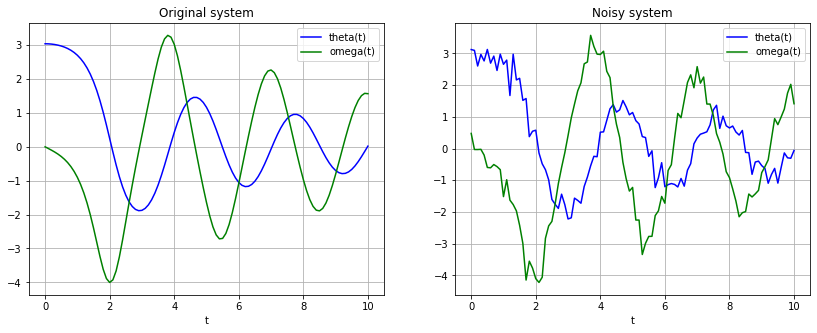

y.shape= (101, 2)


In [ ]:
def pend(y, t, b, c):
  # Example from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
  theta, omega = y
  dydt = [omega, -b*omega - c*np.sin(theta)]
  return dydt

# Define parameters
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)

# Solve system
y = odeint(pend, y0, t, args=(b, c))

f,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t, y[:, 0], 'b', label='theta(t)')
ax[0].plot(t, y[:, 1], 'g', label='omega(t)')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_title('Original system')
ax[0].grid()

# Add noise
sigma = 0.5
y += np.random.normal(0, sigma ** 2, y.shape)

ax[1].plot(t, y[:, 0], 'b', label='theta(t)')
ax[1].plot(t, y[:, 1], 'g', label='omega(t)')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_title('Noisy system')
ax[1].grid()

plt.show()
print("y.shape=",y.shape)

In [ ]:
# Thinning the data set
y_coarse = y[::2]

In [ ]:
def my_loglik(theta, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    theta = np.array(theta).flatten()
    b,c = theta
    output = odeint(pend, y0, t, args=(b, c))
    return -(0.5 / sigma ** 2) * np.sum((output - data) ** 2)

In [ ]:
# Test to see if it works
theta_test = np.array([3,3])
data = y
sigma = 1.0
like = my_loglik(theta_test,data,sigma)

In [ ]:
class LogLike(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables
        # call the log-likelihood function
        logl = self.likelihood(theta, self.data, self.sigma)
        outputs[0][0] = np.array(logl)  # output the log-likelihood

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for i in range(2):
    logl.append(LogLike(my_loglik, data, sigma))

In [ ]:
n_params = 2

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(n_params)
cov_prior = np.eye(n_params)

# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(1):
    with pm.Model() as model:

        # Multivariate normal prior.
        theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(n_params,))

        # Use the Potential class to evaluate likelihood
        pm.Potential("likelihood", logl[j](theta))

    coarse_models.append(model)

Create fine model

In [66]:
with pm.Model() as model:
    # Multivariate normal prior.
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(n_params,))

    # Use the Potential class to evaluate likelihood
    pm.Potential("likelihood", logl[-1](theta))

    # Find the MAP estimate which is used as the starting point for sampling
    MAP = pm.find_MAP()

    # Initialise
    step_mlda = pm.MLDA(
        coarse_models=coarse_models, subsampling_rates=[10]
    )

    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=6000, chains=4, tune=2000, step=step_mlda, random_seed=RANDOM_SEED)
    runtime = time.time() - t_start

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.


/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac92a3c810>,
      dtype=object)

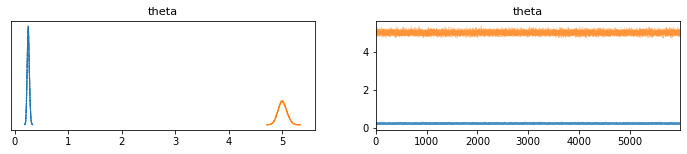

In [67]:
# Trace plots
az.plot_trace(trace)

In [68]:
MAP

{'theta': array([0.24681959, 5.00651528])}

### Old Training

In [ ]:
# Thinning the data set
t_coarse = t[::2]
y_coarse = y[::2]

Define models

In [ ]:
with pm.Model() as fine_model:
  # Define priors
  intercept = pm.Normal("intercept", 0, sigma=20)
  slope = pm.Normal("slope", 0, sigma=20)

  # Define likelihood
  likelihood = pm.Normal("y", mu=intercept + slope * t, sigma=sigma, observed=y[:,0])

In [ ]:
# Constructing the coarse model
with pm.Model() as coarse_model:
  # Define priors
  intercept = pm.Normal("intercept", 0, sigma=20)
  slope = pm.Normal("slope", 0, sigma=20)

  # Define likelihood
  likelihood = pm.Normal("y", mu=intercept + slope * t_coarse, sigma=sigma, observed=y_coarse[:,0])

In [ ]:
with fine_model:
    # Initialise step methods
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[10])
    
    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=6000, chains=4, tune=2000, step=step, random_seed=RANDOM_SEED)
    runtime = time.time() - t_start

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Sequential sampling (4 chains in 1 job)
MLDA: [slope, intercept]


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faca0128350>,
      dtype=object)

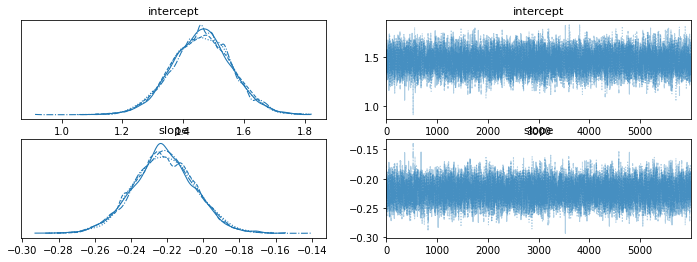

In [ ]:
# Trace plots
az.plot_trace(trace)

In [ ]:
# Summary statistics for MLDA
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.460,0.099,1.268,1.643,0.001,0.001,12896.0,14527.0,1.0
slope,-0.222,0.017,-0.254,-0.190,0.000,0.000,12779.0,14986.0,1.0


In [ ]:
# Try the simple model
mu = trace['intercept'].mean()
slope = trace['slope'].mean()

In [ ]:
y_hat = mu*t+slope

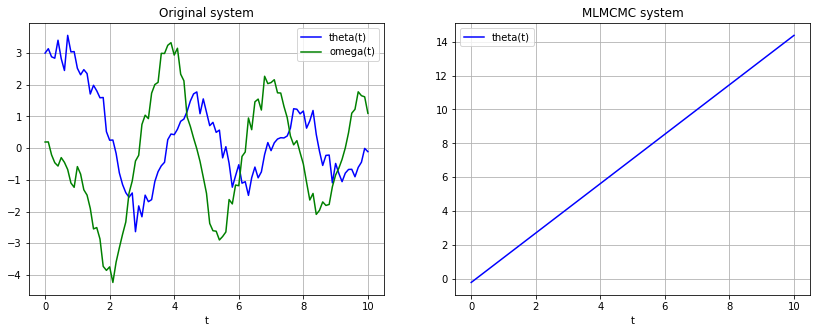

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t, y[:, 0], 'b', label='theta(t)')
ax[0].plot(t, y[:, 1], 'g', label='omega(t)')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_title('Original system')
ax[0].grid()

ax[1].plot(t, y_hat, 'b', label='theta(t)')
# ax[1].plot(t, y_hat, 'g', label='omega(t)')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_title('MLMCMC system')
ax[1].grid()